# IBM Data Science Capstone Project

## 1. Introduction 

Amsterdam is the largest city in the Netherlands with multifarious venues. Therefore to start a food and beverage service is not an easy task. 

A job owner who is living another country wants to open a food and beverage service (like bar, cafe, restaurant) in Amsterdam. Since Amsterdam has lots of place to start a bussiness, the job owner wants to earn money as much as s/he can. There are lots of criteria for this purpose like; population density of a location, number of cafes, restaurants, bars etc.  

In this project, I will show you the analysis of the problem, and try to find the best place to open a food and beverage service in the Amsterdam with an unsupervised learning technique K-means. 

Note: Maximum 100 venues are collected for each district because of the limitation for collecting the venue data. 

### Importing Libraries 

In [1]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

#!conda install -c conda-forge lxml --yes
import lxml

print('Libraries imported.')

Libraries imported.


## 2. Data Preparation

* Related Amsterdam data was taken from https://en.wikipedia.org/wiki/Boroughs_of_Amsterdam
* Coordinates of Amsterdam Boroughs were obtained from Geocoder 
* Venues of Amsterdam were were obtained from Foursquare API

In [2]:
list_df = pd.read_html('https://en.wikipedia.org/wiki/Boroughs_of_Amsterdam')
df = list_df[1]
df

,Borough,Area,Population,Population density,Location (in green),Neighbourhoods
0,Centrum (Centre),8.04 km²,86422,"13,748/km²",NaN,"Binnenstad, Grachtengordel, Haarlemmerbuurt, J..."
1,Noord (North),49.01 km²,94766,"2,269/km²",NaN,"Banne Buiksloot, Buiksloot, Buikslotermeer, Fl..."
2,Nieuw-West(New West),32.38 km²,151677,"4,478/km²",NaN,"Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O..."
3,Oost (East),30.56 km²,135767,"7,635/km²",NaN,"IJburg, Indische Buurt, Eastern Docklands, Oud..."
4,West,9.89 km²,143842,"15,252/km²",NaN,"Frederik Hendrikbuurt, Houthaven, Spaarndammer..."
5,Westpoort(West Gateway),10 km²,192,10/km²,NaN,Westpoort
6,Zuid (South),17.41 km²,144432,"9,349/km²",NaN,"Apollobuurt, Buitenveldert, Hoofddorppleinbuur..."
7,Zuidoost(Southeast),22.08 km²,87854,"4,391/km²",NaN,"Bijlmermeer, Venserpolder, Gaasperdam, Driemond"


Dropping irrelevent columns

In [3]:
df = df.drop(['Area', 'Location (in green)'], axis=1)
df

,Borough,Population,Population density,Neighbourhoods
0,Centrum (Centre),86422,"13,748/km²","Binnenstad, Grachtengordel, Haarlemmerbuurt, J..."
1,Noord (North),94766,"2,269/km²","Banne Buiksloot, Buiksloot, Buikslotermeer, Fl..."
2,Nieuw-West(New West),151677,"4,478/km²","Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O..."
3,Oost (East),135767,"7,635/km²","IJburg, Indische Buurt, Eastern Docklands, Oud..."
4,West,143842,"15,252/km²","Frederik Hendrikbuurt, Houthaven, Spaarndammer..."
5,Westpoort(West Gateway),192,10/km²,Westpoort
6,Zuid (South),144432,"9,349/km²","Apollobuurt, Buitenveldert, Hoofddorppleinbuur..."
7,Zuidoost(Southeast),87854,"4,391/km²","Bijlmermeer, Venserpolder, Gaasperdam, Driemond"


Showing the population of the Boroughs of Amsterdam

192


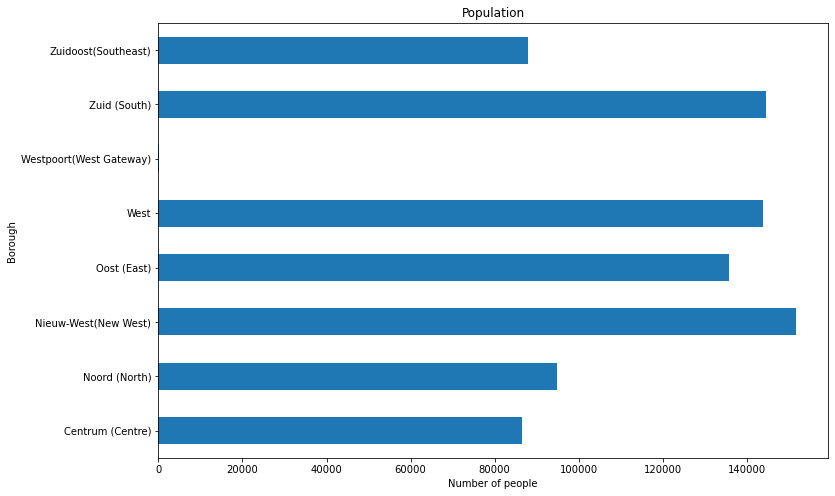

In [4]:
import matplotlib.pyplot as plt

print(df.iloc[5][1])

df[['Borough', 'Population']].plot(kind='barh', figsize=(12, 8), legend = None)

plt.xlabel('Number of people') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Population') # add title to the plot
plt.yticks (np.arange(8), df['Borough'])
plt.show()

In [5]:
df['Borough'] = 'Amsterdam-'+ df['Borough']
df = df.drop([5])
df.reset_index(drop=True, inplace=True)
df

,Borough,Population,Population density,Neighbourhoods
0,Amsterdam-Centrum (Centre),86422,"13,748/km²","Binnenstad, Grachtengordel, Haarlemmerbuurt, J..."
1,Amsterdam-Noord (North),94766,"2,269/km²","Banne Buiksloot, Buiksloot, Buikslotermeer, Fl..."
2,Amsterdam-Nieuw-West(New West),151677,"4,478/km²","Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O..."
3,Amsterdam-Oost (East),135767,"7,635/km²","IJburg, Indische Buurt, Eastern Docklands, Oud..."
4,Amsterdam-West,143842,"15,252/km²","Frederik Hendrikbuurt, Houthaven, Spaarndammer..."
5,Amsterdam-Zuid (South),144432,"9,349/km²","Apollobuurt, Buitenveldert, Hoofddorppleinbuur..."
6,Amsterdam-Zuidoost(Southeast),87854,"4,391/km²","Bijlmermeer, Venserpolder, Gaasperdam, Driemond"


In [6]:
df['Borough'] = df['Borough'].replace({'Amsterdam-Centrum (Centre)':'Amsterdam-Centraal','Amsterdam-Noord (North)':'Amsterdam-Noord',
                      'Amsterdam-Nieuw-West(New West)':'Amsterdam-Nieuw-West','Amsterdam-Oost (East)':'Amsterdam-Oost',
                      'Amsterdam-West':'Amsterdam-West','Amsterdam-Zuid (South)':'Amsterdam-Zuid','Amsterdam-Zuidoost(Southeast)':'Amsterdam-Zuidoost',})
df

,Borough,Population,Population density,Neighbourhoods
0,Amsterdam-Centraal,86422,"13,748/km²","Binnenstad, Grachtengordel, Haarlemmerbuurt, J..."
1,Amsterdam-Noord,94766,"2,269/km²","Banne Buiksloot, Buiksloot, Buikslotermeer, Fl..."
2,Amsterdam-Nieuw-West,151677,"4,478/km²","Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O..."
3,Amsterdam-Oost,135767,"7,635/km²","IJburg, Indische Buurt, Eastern Docklands, Oud..."
4,Amsterdam-West,143842,"15,252/km²","Frederik Hendrikbuurt, Houthaven, Spaarndammer..."
5,Amsterdam-Zuid,144432,"9,349/km²","Apollobuurt, Buitenveldert, Hoofddorppleinbuur..."
6,Amsterdam-Zuidoost,87854,"4,391/km²","Bijlmermeer, Venserpolder, Gaasperdam, Driemond"


Load the coordinates of the boroughs

In [7]:
columns = ['Borough', 'Population','Population density','Neighbourhoods'] 

df_merge = pd.DataFrame(columns=columns)

borough = df['Borough']
population = df['Population']
p_density = df['Population density']
neigh = df['Neighbourhoods']

location = None
latitude = None
longitude = None

for data in range(0, len(borough)):
    br = borough[data]
    pop = population[data]
    dens = p_density[data]
    neig= neigh[data]
    geolocator = Nominatim(user_agent="user-agent='my_email@myserver.com")
    location = geolocator.geocode('{}'.format(br))
    latitude = location.latitude
    longitude = location.longitude
    
    df_merge = df_merge.append({ 'Borough':br,'Population':pop,'Population density':dens,'Neighbourhoods': neig,'Latitude': location.latitude,'Longitude': location.longitude}, ignore_index=True)
    
df_merge

,Borough,Population,Population density,Neighbourhoods,Latitude,Longitude
0,Amsterdam-Centraal,86422,"13,748/km²","Binnenstad, Grachtengordel, Haarlemmerbuurt, J...",52.378901,4.900581
1,Amsterdam-Noord,94766,"2,269/km²","Banne Buiksloot, Buiksloot, Buikslotermeer, Fl...",52.409745,4.931931
2,Amsterdam-Nieuw-West,151677,"4,478/km²","Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O...",52.363777,4.813812
3,Amsterdam-Oost,135767,"7,635/km²","IJburg, Indische Buurt, Eastern Docklands, Oud...",52.356608,4.930577
4,Amsterdam-West,143842,"15,252/km²","Frederik Hendrikbuurt, Houthaven, Spaarndammer...",52.376672,4.863724
5,Amsterdam-Zuid,144432,"9,349/km²","Apollobuurt, Buitenveldert, Hoofddorppleinbuur...",52.339017,4.873432
6,Amsterdam-Zuidoost,87854,"4,391/km²","Bijlmermeer, Venserpolder, Gaasperdam, Driemond",52.299626,4.947501


In [8]:
geolocator = Nominatim(user_agent='my_email@myserver.com')
location = geolocator.geocode('Amsterdam')
latitude = location.latitude
longitude = location.longitude

print('The geographical coordinate of Amsterdam are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Amsterdam are 52.3727598, 4.8936041.


Showing the centre location of each borough

In [9]:
map_amsterdam = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district in zip(df_merge['Latitude'], df_merge['Longitude'], df_merge['Borough']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,).add_to(map_amsterdam)  
map_amsterdam

In [10]:
df_merge['Borough'] = df_merge['Borough'].replace({'Amsterdam-Centrum (Centre)':'Amsterdam-Centrum','Amsterdam-Noord (North)':'Amsterdam-Noord',
                      'Amsterdam-Nieuw-West(New West)':'Amsterdam-Nieuw-West','Amsterdam-Oost (East)':'Amsterdam-Oost',
                      'Amsterdam-West':'Amsterdam-West','Amsterdam-Zuid (South)':'Amsterdam-Zuid','Amsterdam-Zuidoost(Southeast)':'Amsterdam-Zuidoost',})
df_merge

,Borough,Population,Population density,Neighbourhoods,Latitude,Longitude
0,Amsterdam-Centraal,86422,"13,748/km²","Binnenstad, Grachtengordel, Haarlemmerbuurt, J...",52.378901,4.900581
1,Amsterdam-Noord,94766,"2,269/km²","Banne Buiksloot, Buiksloot, Buikslotermeer, Fl...",52.409745,4.931931
2,Amsterdam-Nieuw-West,151677,"4,478/km²","Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O...",52.363777,4.813812
3,Amsterdam-Oost,135767,"7,635/km²","IJburg, Indische Buurt, Eastern Docklands, Oud...",52.356608,4.930577
4,Amsterdam-West,143842,"15,252/km²","Frederik Hendrikbuurt, Houthaven, Spaarndammer...",52.376672,4.863724
5,Amsterdam-Zuid,144432,"9,349/km²","Apollobuurt, Buitenveldert, Hoofddorppleinbuur...",52.339017,4.873432
6,Amsterdam-Zuidoost,87854,"4,391/km²","Bijlmermeer, Venserpolder, Gaasperdam, Driemond",52.299626,4.947501


**Foursquare Credentials and Version**

In [11]:
CLIENT_ID = 'B2AYWF55DCNIB0MKHCZ4PAEYJ3LY20HNKVFYTSYKDHWVE21Y' #  Foursquare ID
CLIENT_SECRET = 'CESUVX5JIDYZHZN0ORATKUU01YFC5OI0W0E5S0WWU0JE2D1S' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B2AYWF55DCNIB0MKHCZ4PAEYJ3LY20HNKVFYTSYKDHWVE21Y
CLIENT_SECRET:CESUVX5JIDYZHZN0ORATKUU01YFC5OI0W0E5S0WWU0JE2D1S


Exploring the venues of Amsterdam boroughs

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
LIMIT = 100
radius = 1000
amsterdam_venue = getNearbyVenues(names=df_merge['Borough'],
                                   latitudes=df_merge['Latitude'],
                                   longitudes=df_merge['Longitude'],
                                   radius = radius
                                  )

Amsterdam-Centraal
Amsterdam-Noord
Amsterdam-Nieuw-West
Amsterdam-Oost
Amsterdam-West
Amsterdam-Zuid
Amsterdam-Zuidoost


In [14]:
print(amsterdam_venue.shape)
amsterdam_venue.head()

(471, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amsterdam-Centraal,52.378901,4.900581,Chocolate Company,52.378626,4.899778,Chocolate Shop
1,Amsterdam-Centraal,52.378901,4.900581,art'otel,52.377640,4.897160,Hotel
2,Amsterdam-Centraal,52.378901,4.900581,Station Amsterdam Centraal,52.378782,4.900374,Train Station
3,Amsterdam-Centraal,52.378901,4.900581,Vermeer,52.376669,4.900454,French Restaurant
4,Amsterdam-Centraal,52.378901,4.900581,Omelegg - City Centre,52.376060,4.899802,Breakfast Spot


Showing how many venues each borough have

In [15]:
amsterdam_venue.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Amsterdam-Centraal,100,100,100,100,100,100
Amsterdam-Nieuw-West,42,42,42,42,42,42
Amsterdam-Noord,5,5,5,5,5,5
Amsterdam-Oost,83,83,83,83,83,83
Amsterdam-West,100,100,100,100,100,100
Amsterdam-Zuid,100,100,100,100,100,100
Amsterdam-Zuidoost,41,41,41,41,41,41


In [16]:
#amsterdam_venue['Venue Category'].value_counts()

## 3. Methodology and Analysis 

Applying One-Hot Encoding

In [17]:
# one hot encoding
amsterdam_onehot = pd.get_dummies(amsterdam_venue[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
amsterdam_onehot['Borough'] = amsterdam_venue['Borough'] 

# move neighborhood column to the first column
fixed_columns = [amsterdam_onehot.columns[-1]] + list(amsterdam_onehot.columns[:-1])
amsterdam_onehot = amsterdam_onehot[fixed_columns]

amsterdam_onehot.head()

,Borough,Arcade,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Bus Stop,Cafeteria,Café,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Drugstore,Dutch Restaurant,Electronics Store,Empanada Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gay Bar,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health Food Store,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Lake,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nightclub,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Pet Café,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Ramen Restaurant,Recreation Center,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spiritual Center,Sporting Goods Shop,Sports Club,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,Amsterdam-Centraal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Amsterdam-Centraal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Amsterdam-Centraal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Amsterdam-Centraal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Amsterdam-Centraal,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
amsterdam_gr = amsterdam_onehot.groupby('Borough').mean().reset_index()
amsterdam_gr

,Borough,Arcade,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Bus Stop,Cafeteria,Café,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Drugstore,Dutch Restaurant,Electronics Store,Empanada Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gay Bar,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health Food Store,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Lake,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nightclub,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Pet Café,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Ramen Restaurant,Recreation Center,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spiritual Center,Sporting Goods Shop,Sports Club,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,Amsterdam-Centraal,0.01,0.01,0.010000,0.000000,0.00000,0.010000,0.050000,0.010000,0.000000,0.01,0.01000,0.00,0.000000,0.01,0.010000,0.00,0.020000,0.01,0.000000,0.00000,0.030000,0.000000,0.000000,0.020000,0.00000,0.02,0.02,0.020000,0.020000,0.060000,0.000000,0.01,0.00000,0.01,0.01,0.00,0.010000,0.01000,0.01,0.01,0.000000,0.00,0.00,0.000000,0.00000,0.00000,0.00,0.00,0.000000,0.000000,0.00000,0.00000,0.030000,0.00000,0.000000,0.01,0.000000,0.01,0.00,0.0,0.00,0.010000,0.000000,0.000000,0.00,0.00,0.020000,0.070000,0.02000,0.00000,0.010000,0.00000,0.01,0.000000,0.010000,0.00,0.00000,0.00,0.01,0.000000,0.01,0.04,0.000000,0.00000,0.01000,0.00000,0.00,0.000000,0.000000,0.00000,0.01,0.020000,0.000000,0.01,0.01,0.000000,0.00000,0.00000,0.000000,0.00,0.00,0.000000,0.01000,0.00000,0.00,0.00000,0.000000,0.00000,0.00,0.00000,0.040000,0.00,0.000000,0.050000,0.00,0.01,0.01000,0.00000,0.01,0.000000,0.00,0.000000,0.00000,0.000000,0.01000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.02,0.00,0.000000,0.00,0.01,0.01,0.010000,0.000000,0.02,0.00000,0.000000,0.01,0.000000,0.000000,0.01,0.000000,0.01,0.01,0.00,0.00
1,Amsterdam-Nieuw-West,0.00,0.00,0.023810,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.047619,0.00000,0.000000,0.000000,0.000000,0.000000,0.02381,0.00,0.00,0.047619,0.000000,0.000000,0.000000,0.00,0.00000,0.00,0.00,0.00,0.000000,0.02381,0.00,0.00,0.023810,0.00,0.00,0.047619,0.02381,0.00000,0.00,0.00,0.000000,0.023810,0.00000,0.00000,0.000000,0.00000,0.000000,0.00,0.000000,0.00,0.00,0.0,0.00,0.000000,0.047619,0.023810,0.00,0.00,0.000000,0.023810,0.00000,0.02381,0.000000,0.02381,0.00,0.000000,0.000000,0.00,0.02381,0.00,0.00,0.000000,0.00,0.00,0.000000,0.02381,0.02381,0.00000,0.00,0.000000,0.000000,0.02381,

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Showing the most common venues for each borough

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Borough'] = amsterdam_gr['Borough']

for ind in np.arange(amsterdam_gr.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(amsterdam_gr.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amsterdam-Centraal,Hotel,Coffee Shop,Restaurant,Bar,Marijuana Dispensary,Pub,Café,French Restaurant,Chocolate Shop,Church
1,Amsterdam-Nieuw-West,Gym,Trail,Soccer Field,Bus Stop,Clothing Store,Supermarket,Drugstore,Theater,Shopping Mall,Mediterranean Restaurant
2,Amsterdam-Noord,Bus Stop,Golf Course,Monument / Landmark,Gym / Fitness Center,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Court,Food & Drink Shop,Fast Food Restaurant
3,Amsterdam-Oost,Bar,Café,Coffee Shop,Italian Restaurant,French Restaurant,Ice Cream Shop,Market,Restaurant,Bakery,Cocktail Bar
4,Amsterdam-West,Bar,Coffee Shop,Italian Restaurant,Restaurant,Café,Pizza Place,Grocery Store,Park,Vegetarian / Vegan Restaurant,Gym / Fitness Center


In [21]:
amsterdam_beer = amsterdam_venue[(amsterdam_venue['Venue Category'].str.contains('Beer', regex=False)) |
                 (amsterdam_venue['Venue Category'].str.contains('Bar', regex=False)) ].groupby(['Borough']).count()
amsterdam_beer.drop(['Borough Latitude', 'Borough Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
amsterdam_beer.rename(columns = {'Venue Category':'Number of Bars'}, inplace=True)
amsterdam_beer.head()

,Number of Bars
Borough,
Amsterdam-Centraal,12
Amsterdam-Oost,10
Amsterdam-West,12
Amsterdam-Zuid,4
Amsterdam-Zuidoost,1


In [22]:
amsterdam_cafe = amsterdam_venue[(amsterdam_venue['Venue Category'].str.contains('Café', regex=False)) |
                 (amsterdam_venue['Venue Category'].str.contains('Cafe', regex=False))].groupby(['Borough']).count()
amsterdam_cafe.drop(['Borough Latitude', 'Borough Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
amsterdam_cafe.rename(columns = {'Venue Category':'Number of Cafes'}, inplace=True)
amsterdam_cafe.head()

,Number of Cafes
Borough,
Amsterdam-Centraal,3
Amsterdam-Oost,6
Amsterdam-West,5
Amsterdam-Zuid,2
Amsterdam-Zuidoost,3


In [23]:
amsterdam_rest = amsterdam_venue[(amsterdam_venue['Venue Category'].str.contains('Restaurant', regex=False)) |
                 (amsterdam_venue['Venue Category'].str.contains('Dutch Restaurant', regex=False)) ].groupby(['Borough']).count()
amsterdam_rest.drop(['Borough Latitude', 'Borough Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
amsterdam_rest.rename(columns = {'Venue Category':'Number of Restaurants'}, inplace=True)
amsterdam_rest.head()

,Number of Restaurants
Borough,
Amsterdam-Centraal,15
Amsterdam-Nieuw-West,9
Amsterdam-Oost,23
Amsterdam-West,30
Amsterdam-Zuid,23


In [24]:
amsterdam_gr = amsterdam_gr.join(amsterdam_rest, on='Borough')
amsterdam_gr = amsterdam_gr.join(amsterdam_cafe, on='Borough')
amsterdam_gr = amsterdam_gr.join(amsterdam_beer, on='Borough')
amsterdam_gr= amsterdam_gr.fillna(0)
amsterdam_gr

,Borough,Arcade,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Bus Stop,Cafeteria,Café,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Drugstore,Dutch Restaurant,Electronics Store,Empanada Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gay Bar,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health Food Store,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Lake,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nightclub,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Pet Café,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Ramen Restaurant,Recreation Center,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spiritual Center,Sporting Goods Shop,Sports Club,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Shop,Yoga Studio,Number of Restaurants,Number of Cafes,Number of Bars
0,Amsterdam-Centraal,0.01,0.01,0.010000,0.000000,0.00000,0.010000,0.050000,0.010000,0.000000,0.01,0.01000,0.00,0.000000,0.01,0.010000,0.00,0.020000,0.01,0.000000,0.00000,0.030000,0.000000,0.000000,0.020000,0.00000,0.02,0.02,0.020000,0.020000,0.060000,0.000000,0.01,0.00000,0.01,0.01,0.00,0.010000,0.01000,0.01,0.01,0.000000,0.00,0.00,0.000000,0.00000,0.00000,0.00,0.00,0.000000,0.000000,0.00000,0.00000,0.030000,0.00000,0.000000,0.01,0.000000,0.01,0.00,0.0,0.00,0.010000,0.000000,0.000000,0.00,0.00,0.020000,0.070000,0.02000,0.00000,0.010000,0.00000,0.01,0.000000,0.010000,0.00,0.00000,0.00,0.01,0.000000,0.01,0.04,0.000000,0.00000,0.01000,0.00000,0.00,0.000000,0.000000,0.00000,0.01,0.020000,0.000000,0.01,0.01,0.000000,0.00000,0.00000,0.000000,0.00,0.00,0.000000,0.01000,0.00000,0.00,0.00000,0.000000,0.00000,0.00,0.00000,0.040000,0.00,0.000000,0.050000,0.00,0.01,0.01000,0.00000,0.01,0.000000,0.00,0.000000,0.00000,0.000000,0.01000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.02,0.00,0.000000,0.00,0.01,0.01,0.010000,0.000000,0.02,0.00000,0.000000,0.01,0.000000,0.000000,0.01,0.000000,0.01,0.01,0.00,0.00,15.0,3.0,12.0
1,Amsterdam-Nieuw-West,0.00,0.00,0.023810,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.047619,0.00000,0.000000,0.000000,0.000000,0.000000,0.02381,0.00,0.00,0.047619,0.000000,0.000000,0.000000,0.00,0.00000,0.00,0.00,0.00,0.000000,0.02381,0.00,0.00,0.023810,0.00,0.00,0.047619,0.02381,0.00000,0.00,0.00,0.000000,0.023810,0.00000,0.00000,0.000000,0.00000,0.000000,0.00,0.000000,0.00,0.00,0.0,0.00,0.000000,0.047619,0.023810,0.00,0.00,0.000000,0.023810,0.00000,0.02381,0.000000,0.02381,0.00,0.000000,0.000000,0.00,0.02381,0.00,0.00,0.000000,0.00,0.

Graph of number of restaurants, bars and cafes for each borough

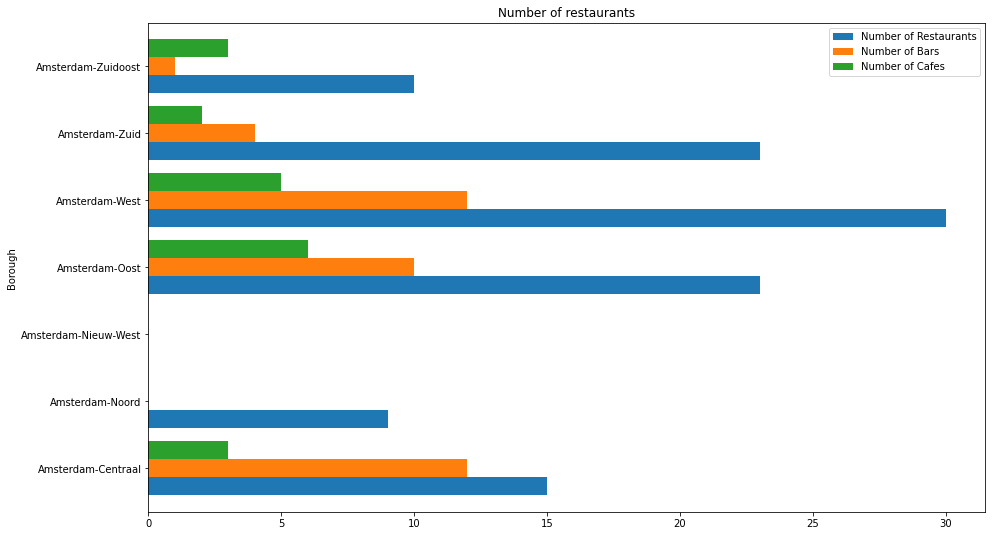

In [25]:
amsterdam_gr[['Number of Restaurants', 'Number of Bars','Number of Cafes']].plot(kind='barh', figsize=(15, 9), width = 0.8)

#plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Borough') # add y-label to the plot
plt.title('Number of restaurants') # add title to the plot
plt.yticks (np.arange(7), df['Borough'])
plt.show()

In [26]:
amsterdam_last = amsterdam_gr.drop(['Borough'], axis=1)
amsterdam_last

,Arcade,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Bus Stop,Cafeteria,Café,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dive Bar,Drugstore,Dutch Restaurant,Electronics Store,Empanada Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gay Bar,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health Food Store,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Lake,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nightclub,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Pet Café,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Ramen Restaurant,Recreation Center,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Spa,Spiritual Center,Sporting Goods Shop,Sports Club,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Shop,Yoga Studio,Number of Restaurants,Number of Cafes,Number of Bars
0,0.01,0.01,0.010000,0.000000,0.00000,0.010000,0.050000,0.010000,0.000000,0.01,0.01000,0.00,0.000000,0.01,0.010000,0.00,0.020000,0.01,0.000000,0.00000,0.030000,0.000000,0.000000,0.020000,0.00000,0.02,0.02,0.020000,0.020000,0.060000,0.000000,0.01,0.00000,0.01,0.01,0.00,0.010000,0.01000,0.01,0.01,0.000000,0.00,0.00,0.000000,0.00000,0.00000,0.00,0.00,0.000000,0.000000,0.00000,0.00000,0.030000,0.00000,0.000000,0.01,0.000000,0.01,0.00,0.0,0.00,0.010000,0.000000,0.000000,0.00,0.00,0.020000,0.070000,0.02000,0.00000,0.010000,0.00000,0.01,0.000000,0.010000,0.00,0.00000,0.00,0.01,0.000000,0.01,0.04,0.000000,0.00000,0.01000,0.00000,0.00,0.000000,0.000000,0.00000,0.01,0.020000,0.000000,0.01,0.01,0.000000,0.00000,0.00000,0.000000,0.00,0.00,0.000000,0.01000,0.00000,0.00,0.00000,0.000000,0.00000,0.00,0.00000,0.040000,0.00,0.000000,0.050000,0.00,0.01,0.01000,0.00000,0.01,0.000000,0.00,0.000000,0.00000,0.000000,0.01000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.02,0.00,0.000000,0.00,0.01,0.01,0.010000,0.000000,0.02,0.00000,0.000000,0.01,0.000000,0.000000,0.01,0.000000,0.01,0.01,0.00,0.00,15.0,3.0,12.0
1,0.00,0.00,0.023810,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.047619,0.00000,0.000000,0.000000,0.000000,0.000000,0.02381,0.00,0.00,0.047619,0.000000,0.000000,0.000000,0.00,0.00000,0.00,0.00,0.00,0.000000,0.02381,0.00,0.00,0.023810,0.00,0.00,0.047619,0.02381,0.00000,0.00,0.00,0.000000,0.023810,0.00000,0.00000,0.000000,0.00000,0.000000,0.00,0.000000,0.00,0.00,0.0,0.00,0.000000,0.047619,0.023810,0.00,0.00,0.000000,0.023810,0.00000,0.02381,0.000000,0.02381,0.00,0.000000,0.000000,0.00,0.02381,0.00,0.00,0.000000,0.00,0.00,0.000000,0.02381,0.02381,0.00000,0.00,0.00000

### **Clustering with K-Means**

Elbow method is used for identifying the best number of cluster

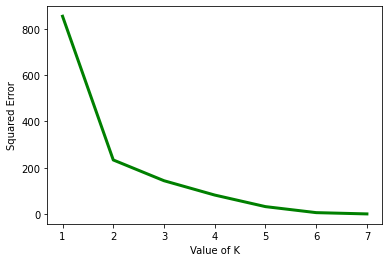

In [27]:
cost =[] 
for i in range(1, 8): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(amsterdam_last) 
    cost.append(KM.inertia_)      
  
plt.plot(range(1, 8), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Squared Error") 
plt.show()

2 cluster is the best for our purpose

In [28]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(amsterdam_last)
kmeans.labels_[0:]

array([0, 1, 1, 0, 0, 0, 1], dtype=int32)

In [29]:
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#venues_sorted

Inserting the cluster labels into the main dataframe

In [30]:
df_merge.insert(0, 'Cluster Labels', kmeans.labels_)
df_merge

,Cluster Labels,Borough,Population,Population density,Neighbourhoods,Latitude,Longitude
0,0,Amsterdam-Centraal,86422,"13,748/km²","Binnenstad, Grachtengordel, Haarlemmerbuurt, J...",52.378901,4.900581
1,1,Amsterdam-Noord,94766,"2,269/km²","Banne Buiksloot, Buiksloot, Buikslotermeer, Fl...",52.409745,4.931931
2,1,Amsterdam-Nieuw-West,151677,"4,478/km²","Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O...",52.363777,4.813812
3,0,Amsterdam-Oost,135767,"7,635/km²","IJburg, Indische Buurt, Eastern Docklands, Oud...",52.356608,4.930577
4,0,Amsterdam-West,143842,"15,252/km²","Frederik Hendrikbuurt, Houthaven, Spaarndammer...",52.376672,4.863724
5,0,Amsterdam-Zuid,144432,"9,349/km²","Apollobuurt, Buitenveldert, Hoofddorppleinbuur...",52.339017,4.873432
6,1,Amsterdam-Zuidoost,87854,"4,391/km²","Bijlmermeer, Venserpolder, Gaasperdam, Driemond",52.299626,4.947501


Illustrating the clusters

In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(2)
ys = [i + x + (i*x)**2 for i in range(2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merge['Latitude'], df_merge['Longitude'], df_merge['Borough'], df_merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining the Clusters

**Cluster 1**

In [32]:
venues_sorted[(venues_sorted['Cluster Labels'] == 0)]

,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Amsterdam-Centraal,Hotel,Coffee Shop,Restaurant,Bar,Marijuana Dispensary,Pub,Café,French Restaurant,Chocolate Shop,Church
3,0,Amsterdam-Oost,Bar,Café,Coffee Shop,Italian Restaurant,French Restaurant,Ice Cream Shop,Market,Restaurant,Bakery,Cocktail Bar
4,0,Amsterdam-West,Bar,Coffee Shop,Italian Restaurant,Restaurant,Café,Pizza Place,Grocery Store,Park,Vegetarian / Vegan Restaurant,Gym / Fitness Center
5,0,Amsterdam-Zuid,Coffee Shop,Italian Restaurant,Restaurant,Bakery,Supermarket,Hotel,Department Store,Breakfast Spot,Plaza,Salad Place


**Cluster 2**

In [33]:
venues_sorted[(venues_sorted['Cluster Labels'] == 1)]

,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,1,Amsterdam-Nieuw-West,Gym,Trail,Soccer Field,Bus Stop,Clothing Store,Supermarket,Drugstore,Theater,Shopping Mall,Mediterranean Restaurant
2,1,Amsterdam-Noord,Bus Stop,Golf Course,Monument / Landmark,Gym / Fitness Center,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Court,Food & Drink Shop,Fast Food Restaurant
6,1,Amsterdam-Zuidoost,Restaurant,Furniture / Home Store,Hotel,Coffee Shop,Fast Food Restaurant,Café,Bagel Shop,Hotel Bar,Food & Drink Shop,Food Court


## 4. Conclusion

To conclude, two clusters were defined. Cluster 1 (Cluster Label = 0), which includes Centraal, Oost, West and Zuid, has mostly Bars, Cafes and Restaurants. And Cluster 2 (Cluster Label = 1), which includes  Nieuw-West, Noord, Zuidoost, mostly has Stores, Bus Stops, Gyms etc.

Since, density rates in descenting order as follows: West, Centraal, Zuid, Oost, we can say that:

* If s/he want to run a bar; s/he should prefer West, Centraal, Oost respectively,
* If s/he want to run a café; s/he should prefer Oost, West,
* If s/he want to run a restaurant; s/he should prefer West, Zuid, Oost respectively.